**Skin Cancer Detection using CLIP**\
Name : Andi Analta Dwiyanto Palalangan Tunru\
ID : 2024962230

The notebook includes the code for both augmented dataset and non-augmented dataset runs. Please check section 2 of the notebook and choose one of the subsections

#1. Imports

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset
dataset = load_dataset("marmal88/skin_cancer")

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'image_id', 'lesion_id', 'dx', 'dx_type', 'age', 'sex', 'localization'],
        num_rows: 9577
    })
    validation: Dataset({
        features: ['image', 'image_id', 'lesion_id', 'dx', 'dx_type', 'age', 'sex', 'localization'],
        num_rows: 2492
    })
    test: Dataset({
        features: ['image', 'image_id', 'lesion_id', 'dx', 'dx_type', 'age', 'sex', 'localization'],
        num_rows: 1285
    })
})

In [ ]:
dataset["train"][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450>,
 'image_id': 'ISIC_0024329',
 'lesion_id': 'HAM_0002954',
 'dx': 'actinic_keratoses',
 'dx_type': 'histo',
 'age': 75.0,
 'sex': 'female',
 'localization': 'lower extremity'}

In [ ]:
def collate_fn(batch):
    pixel_values = torch.stack([example["pixel_values"] for example in batch])
    labels = torch.tensor([example["labels"] for example in batch])
    return {"pixel_values": pixel_values, "labels": labels}

#2. Data Preparation

In [ ]:
import torch
from transformers import CLIPProcessor
from torch.utils.data import DataLoader

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

labels = dataset["train"].unique("dx")
label_to_id = {label: idx for idx, label in enumerate(labels)}

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
# Set seed value
seed_value = 42

# Seed all random sources
torch.manual_seed(seed_value)
np.random.seed(seed_value)

# For CUDA (if used)
torch.cuda.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)  # For multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

##2.1 Augmented Data

In [ ]:
from torchvision.transforms import Compose, RandomHorizontalFlip, RandomCrop, ColorJitter, Resize, ToTensor

# Augmentations
train_augmentations = Compose([
    Resize((256, 256)),
    RandomCrop((224, 224)),
    RandomHorizontalFlip(p=0.5),
    ToTensor(),
])

val_augmentations = Compose([
    Resize((224, 224)),
    ToTensor(),
])


In [ ]:
from datasets import concatenate_datasets

# Duplicate the training dataset
duplicated_train_dataset = concatenate_datasets([dataset["train"], dataset["train"]])

In [ ]:
def preprocess_train(examples):
    num_samples = len(examples["image"])
    half = num_samples // 2

    # Original images (first half)
    original_images = [Resize((224, 224))(img) if not isinstance(img, torch.Tensor) else img for img in examples["image"][:half]]
    original_labels = [label_to_id[label] for label in examples["dx"][:half]]
    original_texts = [f"The lesion shows signs of {label}" for label in examples["dx"][:half]]

    # Augmented images (second half)
    augmented_images = [train_augmentations(img) if not isinstance(img, torch.Tensor) else img for img in examples["image"][half:]]
    augmented_labels = [label_to_id[label] for label in examples["dx"][half:]]
    augmented_texts = [f"The lesion shows signs of {label}" for label in examples["dx"][half:]]

    # Combine images, labels, and texts
    combined_images = original_images + augmented_images
    combined_labels = original_labels + augmented_labels
    combined_texts = original_texts + augmented_texts

    text_inputs = processor(
        text=combined_texts,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=77,
    )

    processed = {
        "pixel_values": torch.stack([img if isinstance(img, torch.Tensor) else ToTensor()(img) for img in combined_images]),
        "input_ids": text_inputs.input_ids,
        "attention_mask": text_inputs.attention_mask,
        "labels": torch.tensor(combined_labels),
    }
    return processed


def preprocess_val(examples):
    resized_images = [val_augmentations(img) for img in examples["image"]]

    text_inputs = processor(
        text=[f"The lesion shows signs of {label}" for label in examples["dx"]],
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=77,
    )

    processed = {
        "pixel_values": torch.stack(resized_images),
        "input_ids": text_inputs.input_ids,
        "attention_mask": text_inputs.attention_mask,
        "labels": torch.tensor([label_to_id[label] for label in examples["dx"]]),
    }
    return processed

In [ ]:
train_dataset = duplicated_train_dataset.with_transform(preprocess_train)
val_dataset = dataset["validation"].with_transform(preprocess_val)

print(train_dataset[0])
print(val_dataset[0])


{'pixel_values': tensor([[[0.7216, 0.7255, 0.7255,  ..., 0.7725, 0.7725, 0.7725],
         [0.7216, 0.7255, 0.7255,  ..., 0.7647, 0.7725, 0.7686],
         [0.7294, 0.7294, 0.7216,  ..., 0.7647, 0.7725, 0.7725],
         ...,
         [0.6706, 0.6784, 0.6863,  ..., 0.7098, 0.6941, 0.6863],
         [0.6706, 0.6706, 0.6784,  ..., 0.7059, 0.6941, 0.6863],
         [0.6745, 0.6745, 0.6784,  ..., 0.6980, 0.6941, 0.6902]],

        [[0.6235, 0.6157, 0.6078,  ..., 0.6392, 0.6431, 0.6392],
         [0.6235, 0.6157, 0.6078,  ..., 0.6353, 0.6392, 0.6392],
         [0.6196, 0.6157, 0.6078,  ..., 0.6353, 0.6392, 0.6392],
         ...,
         [0.5608, 0.5647, 0.5725,  ..., 0.5922, 0.5843, 0.5686],
         [0.5569, 0.5608, 0.5647,  ..., 0.5882, 0.5804, 0.5725],
         [0.5608, 0.5647, 0.5608,  ..., 0.5843, 0.5804, 0.5765]],

        [[0.5765, 0.5725, 0.5647,  ..., 0.6314, 0.6314, 0.6314],
         [0.5765, 0.5725, 0.5647,  ..., 0.6235, 0.6314, 0.6275],
         [0.5843, 0.5804, 0.5686,  ..., 0

In [ ]:
train_dataset

Dataset({
    features: ['image', 'image_id', 'lesion_id', 'dx', 'dx_type', 'age', 'sex', 'localization'],
    num_rows: 19154
})

##2.2 Data Without Augmentation

In [ ]:
def preprocess(examples):
    text_inputs = processor(
        text=[f"This is {label}" for label in examples["dx"]],
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=77,
    )

    image_inputs = processor(
        images=examples["image"],
        return_tensors="pt",
        padding=True,
        truncation=True,
    )

    processed = {
        "pixel_values": image_inputs.pixel_values,
        "input_ids": text_inputs.input_ids,
        "attention_mask": text_inputs.attention_mask,
        "labels": torch.tensor([label_to_id[label] for label in examples["dx"]])
    }
    return processed

In [ ]:
train_dataset = dataset["train"].with_transform(preprocess)
val_dataset = dataset["test"].with_transform(preprocess)

In [ ]:
train_dataset[0]

{'pixel_values': tensor([[[0.7917, 0.7917, 0.8209,  ..., 1.1712, 1.1274, 1.0982],
          [0.8209, 0.8063, 0.7917,  ..., 1.1566, 1.1566, 1.1420],
          [0.8355, 0.8209, 0.7917,  ..., 1.1420, 1.1420, 1.1566],
          ...,
          [0.7333, 0.7479, 0.7479,  ..., 0.9376, 0.9522, 0.8501],
          [0.7479, 0.7479, 0.7479,  ..., 0.8792, 0.8647, 0.8209],
          [0.7771, 0.7771, 0.7625,  ..., 0.8938, 0.8938, 0.8938]],
 
         [[0.4691, 0.4691, 0.4991,  ..., 0.7242, 0.6792, 0.6642],
          [0.4991, 0.4991, 0.4691,  ..., 0.7242, 0.7092, 0.6792],
          [0.5141, 0.5141, 0.4841,  ..., 0.7542, 0.7392, 0.7242],
          ...,
          [0.4090, 0.4240, 0.4240,  ..., 0.6191, 0.6191, 0.5291],
          [0.4390, 0.4390, 0.4390,  ..., 0.5741, 0.5441, 0.4841],
          [0.4691, 0.4691, 0.4540,  ..., 0.5291, 0.5291, 0.4991]],
 
         [[0.5532, 0.5248, 0.5532,  ..., 0.8234, 0.7808, 0.7666],
          [0.5675, 0.5675, 0.5532,  ..., 0.8234, 0.8092, 0.7950],
          [0.5959, 0.595

# 3. Training

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)

In [ ]:
from transformers import CLIPModel
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

num_labels = len(labels)
classifier = nn.Linear(model.config.projection_dim, num_labels)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
classifier.to(device)

scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0

    for batch in train_dataloader:
        images = batch["pixel_values"].to(device)
        texts = batch["input_ids"].to(device)
        attention_masks = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(pixel_values=images, input_ids=texts, attention_mask=attention_masks, return_dict=True)
        image_embeddings = outputs.image_embeds

        logits = classifier(image_embeddings)

        loss = criterion(logits, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Training accuracy
        preds = logits.argmax(dim=-1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    # Training metrics
    train_accuracy = correct_train / total_train
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_dataloader):.4f}, Train Accuracy: {train_accuracy:.4f}, LR: {scheduler.get_last_lr()}")

    scheduler.step()

Epoch 1/20, Loss: 1.6356, Train Accuracy: 0.6675, LR: [5e-05]
Epoch 2/20, Loss: 1.6263, Train Accuracy: 0.6728, LR: [5e-05]
Epoch 3/20, Loss: 1.6145, Train Accuracy: 0.6863, LR: [5e-05]
Epoch 4/20, Loss: 1.6080, Train Accuracy: 0.6969, LR: [5e-05]
Epoch 5/20, Loss: 1.6037, Train Accuracy: 0.7067, LR: [5e-05]
Epoch 6/20, Loss: 1.5867, Train Accuracy: 0.7343, LR: [5e-06]
Epoch 7/20, Loss: 1.5775, Train Accuracy: 0.7529, LR: [5e-06]
Epoch 8/20, Loss: 1.5747, Train Accuracy: 0.7574, LR: [5e-06]
Epoch 9/20, Loss: 1.5702, Train Accuracy: 0.7646, LR: [5e-06]
Epoch 10/20, Loss: 1.5679, Train Accuracy: 0.7678, LR: [5e-06]
Epoch 11/20, Loss: 1.5625, Train Accuracy: 0.7795, LR: [5.000000000000001e-07]
Epoch 12/20, Loss: 1.5612, Train Accuracy: 0.7824, LR: [5.000000000000001e-07]
Epoch 13/20, Loss: 1.5608, Train Accuracy: 0.7832, LR: [5.000000000000001e-07]
Epoch 14/20, Loss: 1.5602, Train Accuracy: 0.7844, LR: [5.000000000000001e-07]
Epoch 15/20, Loss: 1.5596, Train Accuracy: 0.7860, LR: [5.00000

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Validation loop with confusion matrix integration
model.eval()
correct_val = 0
total_val = 0

all_preds = []
all_labels = []

for batch in val_dataloader:
    images = batch["pixel_values"].to(device)
    labels = batch["labels"].to(device)
    texts = [f"The lesion shows signs of {label}" for label in batch["labels"]]

    # Preprocess validation text
    text_inputs = processor(
        text=texts,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=77,
    )
    input_ids = text_inputs["input_ids"].to(device)
    attention_mask = text_inputs["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(
            pixel_values=images,
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        image_embeddings = outputs.image_embeds

        logits = classifier(image_embeddings)
        preds = logits.argmax(dim=-1)

    # Collect predictions and labels for confusion matrix
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

    # Accuracy calculation
    correct_val += (preds == labels).sum().item()
    total_val += labels.size(0)

# Compute validation accuracy
validation_accuracy = correct_val / total_val
print(f"Validation Accuracy: {validation_accuracy:.4f}")

Validation Accuracy: 0.7917


<Figure size 2100x700 with 0 Axes>

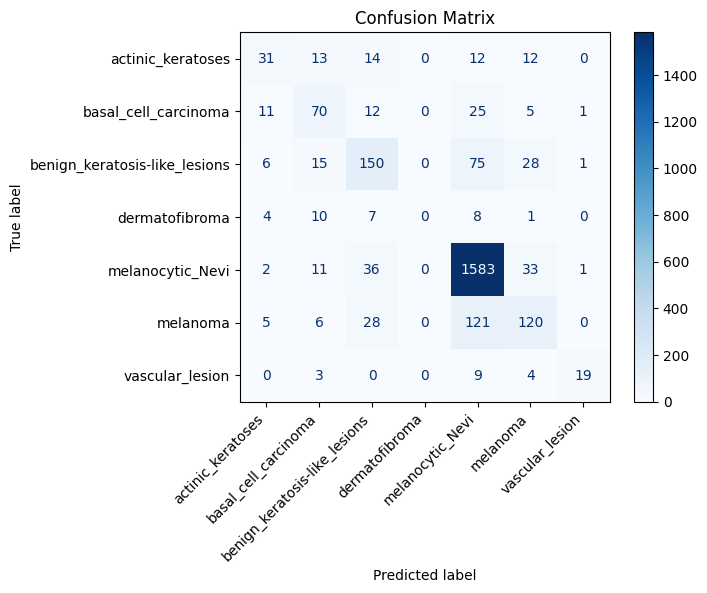

In [ ]:
# Compute confusion matrix
class_names = ['actinic_keratoses',
 'basal_cell_carcinoma',
 'benign_keratosis-like_lesions',
 'dermatofibroma',
 'melanocytic_Nevi',
 'melanoma',
 'vascular_lesion']  # Replace with actual class names
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(21, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.xticks(rotation=45, ha="right")
plt.title("Confusion Matrix")
plt.show()

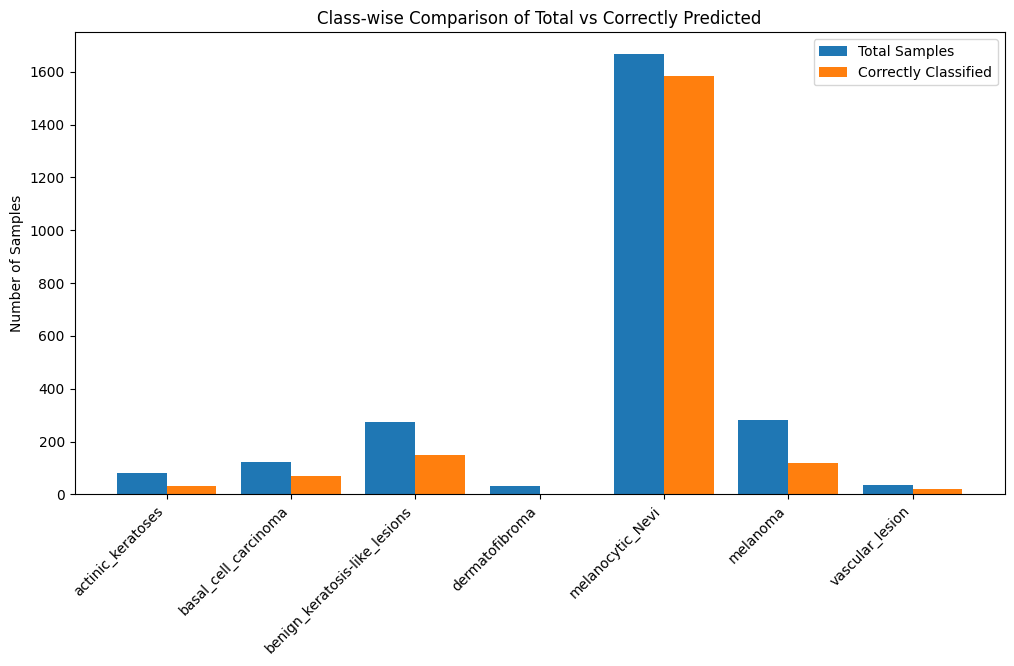

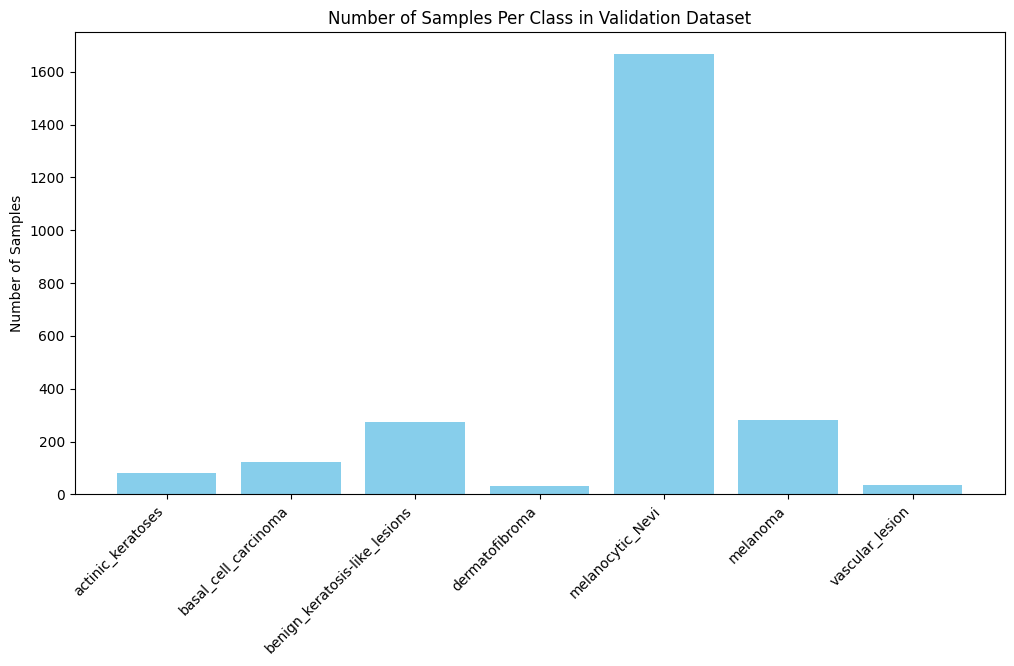

In [ ]:
# Plot class-wise comparison
correct_per_class = np.diag(cm)  # Correct predictions per class
total_per_class = cm.sum(axis=1)  # Total samples per class
class_accuracy = correct_per_class / total_per_class

plt.figure(figsize=(12, 6))
bar_width = 0.4
x = np.arange(len(class_names))

plt.bar(x - bar_width / 2, total_per_class, width=bar_width, label="Total Samples")
plt.bar(x + bar_width / 2, correct_per_class, width=bar_width, label="Correctly Classified")
plt.xticks(x, class_names)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of Samples")
plt.title("Class-wise Comparison of Total vs Correctly Predicted")
plt.legend()
plt.show()

# Plot amount of data for each class in the validation dataset
plt.figure(figsize=(12, 6))
plt.bar(class_names, total_per_class, color='skyblue')
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of Samples")
plt.title("Number of Samples Per Class in Validation Dataset")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Filter the dataset based on diagnosis
filtered_dataset = dataset["train"].filter(lambda example: example["dx"] in ["dermatofibroma", "melanoma", "benign_keratosis-like_lesions", "melanocytic_Nevi"])

Filter:   0%|          | 0/9577 [00:00<?, ? examples/s]

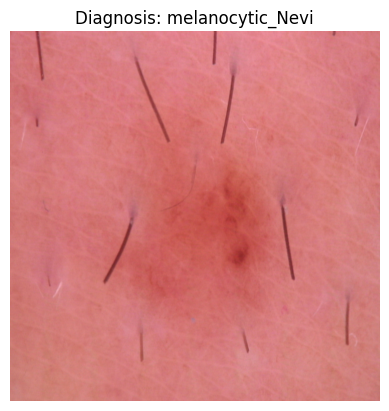

In [ ]:
melano_dataset = filtered_dataset.filter(lambda example: example["dx"] == "melanocytic_Nevi")

image = melano_dataset[10]["image"]  # example["image"] is already a PIL Image

# Resize the image before displaying using Image.resize
image = image.resize((1024, 1024)) # Resize to a smaller size, maintaining aspect ratio


plt.imshow(image)
plt.title(f"Diagnosis: {melano_dataset[0]['dx']}")  # Set title with diagnosis, accessing the first element
plt.axis("off")  # Hide axes
plt.show()

Filter:   0%|          | 0/2234 [00:00<?, ? examples/s]

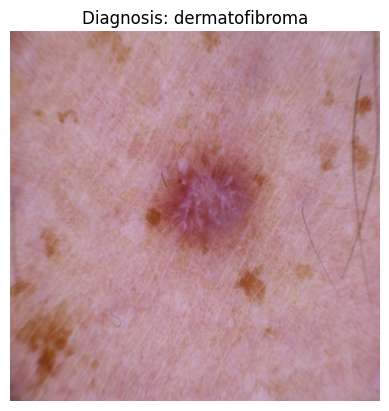

In [ ]:
dermatofibroma_dataset = filtered_dataset.filter(lambda example: example["dx"] == "dermatofibroma")

image = dermatofibroma_dataset[20]["image"]  # example["image"] is already a PIL Image

# Resize the image before displaying using Image.resize
image = image.resize((1024, 1024)) # Resize to a smaller size, maintaining aspect ratio


plt.imshow(image)
plt.title(f"Diagnosis: {dermatofibroma_dataset[0]['dx']}")  # Set title with diagnosis, accessing the first element
plt.axis("off")  # Hide axes
plt.show()

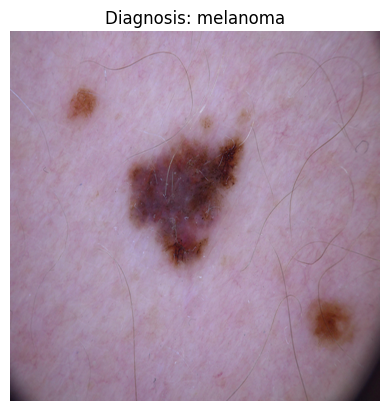

In [ ]:
melanoma_dataset = filtered_dataset.filter(lambda example: example["dx"] == "melanoma")

image = melanoma_dataset[2]["image"]  # example["image"] is already a PIL Image
# Resize the image before displaying using Image.resize
image = image.resize((1024, 1024)) # Resize to a smaller size, maintaining aspect ratio


plt.imshow(image)
plt.title(f"Diagnosis: {melanoma_dataset[0]['dx']}")  # Set title with diagnosis, accessing the first element
plt.axis("off")  # Hide axes
plt.show()

Filter:   0%|          | 0/2234 [00:00<?, ? examples/s]

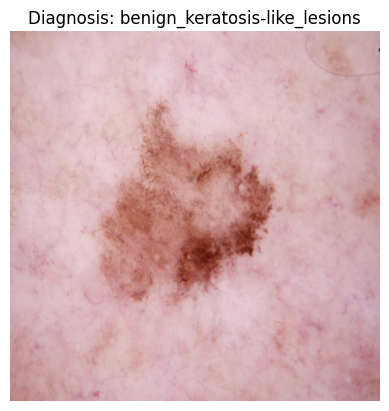

In [ ]:
benign_dataset = filtered_dataset.filter(lambda example: example["dx"] == "benign_keratosis-like_lesions")

image = benign_dataset[5]["image"]  # example["image"] is already a PIL Image
# Resize the image before displaying using Image.resize
image = image.resize((1024, 1024)) # Resize to a smaller size, maintaining aspect ratio


plt.imshow(image)
plt.title(f"Diagnosis: {benign_dataset[0]['dx']}")  # Set title with diagnosis, accessing the first element
plt.axis("off")  # Hide axes
plt.show()

*   Base Results (Batch Size = 16, Initial Learning Rate = 5e-5)
    - Training Accuracy : 0.835
    - Validation Accuracy : 0.818\
    Indicating that the model isn't experiencing overfitting hence there is no need to implement dropout
*   With Regularization (Weight-Decay = 0.01)
    - Training Accuracy : 0.812
    - Validation Accuracy : 0.804
*   Augmented data Setup
    - Training Accuracy : 0.7889
    - Validation Accuracy : 0.7917
